In [ ]:
''' compute distance for each SD intercept, adjust wind to 10m using COARE3.6, 
and compute wind power by water current velocity for now (for simplicity) 

COARE3.6: https://github.com/NOAA-PSL/COARE-algorithm/blob/master/Python/COARE3.6/README.md
Note for getting non-NaNs values from COARE3.6 function "coare36vn_zrf_et"
- wind values has to be positive
- Do not assign NaN values to unknown variables
- can assign zi btw 600 & 300 makes minimal difference in U10, Cd10
- can assign LW_dn btw 350 & 0 makes minimal difference in U10, Cd10
- assign SW_dn = 0 makes almost no difference in U10, Cd10
- assign rain to 0 makes to difference in U10, Cd10
- assign Ss to 0 makes minimal difference in U10, Cd10
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
sys.path.insert(0, path_nhchi)
from windstr import Cd_e13_CH2020, wind_adj2height_PL
from coare36vnWarm_et import coare36vnWarm_et
from coare36vn_zrf_et import coare36vn_zrf_et # output index 1: wind stress, 12: Cd (at height zu), 32: U10, 34: Cdn_10
from compute_distance import distance
from convert_time import datetime_to_yearday

In [2]:
''' Read the time range for SD intercept file '''
year = '2022'
dsec_grid = 600 # sec
path = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/'
fn_intercept = 'time-range_SD_intercept(lt500km)_TCs_NA_'+year+'.txt'
TC_intercept = np.genfromtxt(path+fn_intercept, delimiter=' ',skip_header=1, usecols=(0,1), dtype=str)
ds_intercept = np.genfromtxt(path+fn_intercept, delimiter=' ',skip_header=1, usecols=(2,3,4), dtype=float)
print(type(TC_intercept),TC_intercept[0])
print(type(ds_intercept),ds_intercept[0])
''' settings '''
path_met = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
''' Read the SD-intercept TCs tracks (interp) '''
path = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/data_SD_TC-intercept/'
fn_SD_track = 'SD_intercept_TCs_tracks(interp)_NA_'+year+'.txt'
SD_TC_track_data = np.genfromtxt(path+fn_SD_track, delimiter=' ',skip_header=2, usecols=(0,7),dtype=str)
track_data = np.genfromtxt(path+fn_SD_track, delimiter=' ',skip_header=2, usecols=(1,6,9,10,11,12,13,14),dtype=float)
print('SD_TC track data:',SD_TC_track_data[0])
print('track_data:',track_data[0])

<class 'numpy.ndarray'> ['EARL' '1031']
<class 'numpy.ndarray'> [1.66234170e+09 1.66235268e+09 4.97900000e+02]
SD_TC track data: ['1031' 'EARL']
track_data: [ 1.66234170e+09  4.99999309e+02 -6.50404117e+01  2.00179216e+01
  0.00000000e+00  4.00000000e+00  3.05000000e+02  2.00000000e+00]


2022-SD1031 intercept EARL
tstamp_grid.shape= (18,) 2022-09-04 18:40:00 2022-09-04 21:30:00
lengths of iwnd, icur, icur_met: 184 18 109
List of filled variables with NaNs
0.00% COARE output are NaNs


/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:750: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:715: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43


<Figure size 432x288 with 0 Axes>

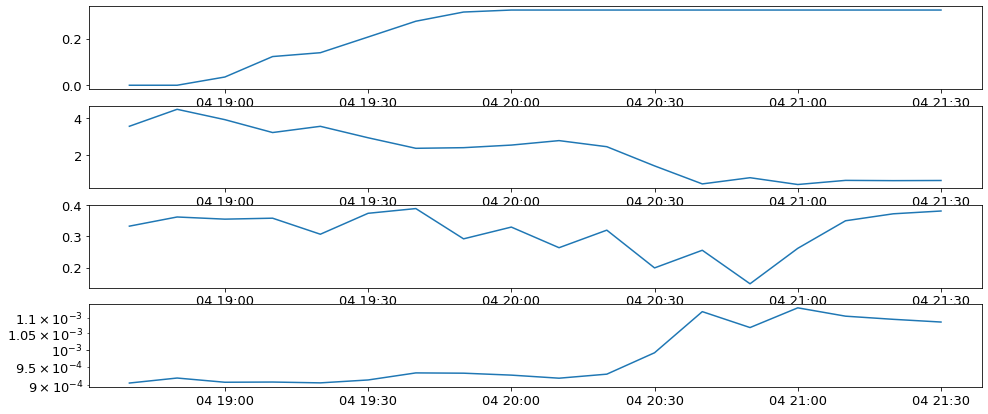

In [43]:
''' plot (1) timeseries of SD measurements during TC intercepts & 
            (2) TC info (distance, category, SD quadrant) '''
vars_met_str = ['longitude','latitude','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','TEMP_SBE37_MEAN','SAL_SBE37_MEAN',\
                'WAVE_SIGNIFICANT_HEIGHT','PAR_AIR_MEAN','UWND_MEAN','VWND_MEAN','WATER_CURRENT_SPEED_MEAN','WATER_CURRENT_DIRECTION_MEAN']
vars_fill_str = ['longitude','latitude','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','TEMP_SBE37_MEAN','SAL_SBE37_MEAN',\
                 'SW_dn','UWND_MEAN','VWND_MEAN']
vals_fill = [-65,25,27,80,1000,28,34,500]
irow_plot = [0,1,2,3,4,5,6,7,8,9,9]
nrow = 4 #irow_plot[-1]
ncol = 1
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','gold','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']
z_inst = np.array([3.5]) # instrument height above the sea surface on Saildrone

''' create an empty dictionary to append data '''
dictionary = {}

''' GO through each row of TC intercept file data '''
for irow, SDname in enumerate( TC_intercept[:,1] ):
    ''' remove all met-ocean, adcp variables '''
    for var in vars_met_str:
        if var in locals():
            exec('del '+var)
        if var+'_fill' in locals():
            exec('del '+var+'_fill')

    ''' TCname '''
    TCname = TC_intercept[irow,0]
    print(year+'-SD'+SDname+' intercept '+TCname)

    ''' Read wind & met data (1-min) '''
    ds_met = nc.Dataset(path_met+'airsea-raw-merge-'+year+'-SD'+SDname+'.nc')
    tstamp_met = np.array([ (datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
                           for item in np.ma.getdata(ds_met.variables['time'][:]) ])
    imet = np.where( (tstamp_met>= ds_intercept[irow,0]) & (tstamp_met<= ds_intercept[irow,1]) )[0]
    dtime_met_plot = np.array([datetime.datetime.fromtimestamp(item) for item in tstamp_met[imet]])
    tstamp_met = tstamp_met[imet]
    _, jday_met = datetime_to_yearday( dtime_met_plot )
    # print('tstamp_met.shape=',tstamp_met.shape, dtime_met_plot[0],dtime_met_plot[-1])

    ''' Read SD alongtrack met-ocean time series '''
    for v, var in enumerate( vars_met_str ):
        data = np.ma.getdata( ds_met.variables[var][:] )[imet]
        if var == 'PAR_AIR_MEAN':
            data = data/2.4 # W/m^2
            exec('SW_dn=data')
        else:
            exec(var+'=data')
    ucur_met = (WATER_CURRENT_SPEED_MEAN * np.sin(WATER_CURRENT_DIRECTION_MEAN/180*np.pi))
    vcur_met = (WATER_CURRENT_SPEED_MEAN * np.cos(WATER_CURRENT_DIRECTION_MEAN/180*np.pi))
    ds_met.close()
    
    ''' Read adcp data (5-min/10-min) '''
    if os.path.isfile(path_adcp+'adcp-raw-merge-'+year+'-SD'+SDname+'.nc'):
        ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+SDname+'.nc')
        tstamp_adcp = np.array([ (datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
                            for item in np.ma.getdata(ds_adcp.variables['time'][:]) ])
        iadcp = np.where( (tstamp_adcp>= ds_intercept[irow,0]) & (tstamp_adcp<= ds_intercept[irow,1]) )[0]
        ''' later average, interpolate all met-ocean, adcp grids within this range with "dsec_grid" time interval '''
        tstamplim = [tstamp_adcp[iadcp][0], tstamp_adcp[iadcp][-1]]
        tstamp_adcp = tstamp_adcp[iadcp]
        tstamp_grid = np.arange(tstamplim[0],tstamplim[-1]+dsec_grid,dsec_grid)
        dtime_grid = np.array([datetime.datetime.fromtimestamp(item) for item in tstamp_grid])
        if len(iadcp)> 0:
            print('tstamp_grid.shape=',tstamp_grid.shape, dtime_grid[0],dtime_grid[-1])
            utemp = np.ma.getdata( ds_adcp.variables['vel_east'][:] )[iadcp,0]
            vtemp = np.ma.getdata( ds_adcp.variables['vel_north'][:] )[iadcp,0]
            ''' interpolate data to gridded times '''
            isok = ~np.isnan( utemp )
            ucur = np.interp( tstamp_grid, tstamp_adcp[isok], utemp[isok] )
            vcur = np.interp( tstamp_grid, tstamp_adcp[isok], vtemp[isok] )
        else:
            print('No available 5/10 min adcp data. Use 1-min adcp data.')
            if np.sum( ~np.isnan(ucur_met) ) > 0:
                ihas_ucur_met = True
            else:
                ihas_ucur_met = False
        ds_adcp.close()
    
    iwnd = ~np.isnan( UWND_MEAN )
    icur = ~np.isnan( ucur )
    icur_met = ~np.isnan( ucur_met )
    print('lengths of iwnd, icur, icur_met:',np.sum(iwnd),np.sum(icur),np.sum(icur_met))
    if (np.sum(iwnd) == 0) & (np.sum(icur) == 0) & (np.sum(icur_met) == 0):
        print('No wind & current data')
    elif (np.sum(iwnd) == 0):
        print('No wind data')
    elif (np.sum(icur) == 0) & (np.sum(icur_met) == 0):
        print('No current data')
    else:
        ones = np.ones( tstamp_grid.shape )
        ''' Average met-ocean data to gridded times & then see if need to fill the gaps to a constant value '''
        print('List of filled variables with NaNs')
        for v, var in enumerate( vars_fill_str ):
            data = eval(var)
            data_fill = np.nan*ones
            ''' average '''
            for i, item in enumerate(tstamp_grid):
                it = np.where( (tstamp_met-item>= -0.5*dsec_grid) & (tstamp_met-item< 0.5*dsec_grid) )[0]
                data_fill[i] = np.nanmean( data[it] )
            ''' see if need to fill all data to a constant value '''
            if np.sum( ~np.isnan(data_fill) ) == 0:
                for k, var_fill_k in enumerate( vars_fill_str ):
                    if var == var_fill_k:
                        data_fill = vals_fill[k]*np.ones( data_fill.shape )
                        print(var+'(all NaNs) is replaced by all',vals_fill[k])
            exec( var+'_fill=data_fill')

        ''' Then, RUN COARE3.6 function to adjust wind to 10 m & get Cd '''
        u3_5m = np.sqrt( np.square(UWND_MEAN_fill) + np.square(VWND_MEAN_fill) )
        res = coare36vn_zrf_et(u=u3_5m, zu=z_inst, t=TEMP_AIR_MEAN_fill, zt=z_inst, rh=RH_MEAN_fill, zq=z_inst, P=BARO_PRES_MEAN_fill, \
                               ts=TEMP_SBE37_MEAN_fill, sw_dn=SW_dn_fill, lw_dn=350*ones, \
                                lat=latitude_fill, lon=longitude_fill, jd = ones, zi=600*ones, rain=0*ones, \
                                Ss=SAL_SBE37_MEAN_fill, zrf_u = 10.0, zrf_t = 10.0,zrf_q = 10.0)
        print('{:.2f}% COARE output are NaNs'.format(np.sum(np.isnan(res))/len(res.flatten())*100) )

        ''' compute largest distance up to from begin of the intercept '''
        distMAX = np.zeros( tstamp_grid.shape )
        for k in range( 0,len(distMAX) ):
            dist_all = []
            lon_comp = longitude_fill[:k]
            lat_comp = latitude_fill[:k]
            for i in range( len(lon_comp) ):
                for j in range( i+1,len(lon_comp) ):
                    dist_all.append( distance(lat_comp[i],lon_comp[i],lat_comp[j],lon_comp[j]) )
            if len( dist_all )> 0:
                distMAX[k] = np.nanmax( dist_all )
        
        ''' Put data to dictionary: u10, v10, U10, Cd10, distMAX '''

        ''' test plot '''
        plt.clf()
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
        fig.set_size_inches(16, 7)
        plt.subplot(nrow,ncol,1)
        plt.plot(dtime_grid, distMAX,label='dist$_{max}$')
        plt.subplot(nrow,ncol,2)
        plt.plot(dtime_grid, res[:,32], label='U10')
        plt.subplot(nrow,ncol,3)
        plt.plot(dtime_grid, np.sqrt( np.square(ucur) + np.square(vcur)),label='curspd' )
        plt.subplot(nrow,ncol,4)
        plt.semilogy(dtime_grid, res[:,34], label='Cd10')

        ''' add TC info - find the rows in SD_intercept_TCs_tracks(interp)_NA file '''
        # irow_SD_TC = np.where( (SD_TC_track_data[:,0] == SDname) & (SD_TC_track_data[:,1] == TCname) )[0]
        # dtime_track_data = np.array([datetime.datetime.fromtimestamp(item) for item in track_data[irow_SD_TC,0]])
    
    ''' save figure '''
    if irow == 0:
        break